# Performing medical imaging segmentation like a pro (Bonus)
*A highly oppiniated and biased tutorial on MRI lesion segmentation using Pytorch*

**Sergi Valverde, PhD**
*Universitat de Girona, Spain*



# Bonus Track:

During this extra notebook, we will cover some tricks to use the same U-NET model for brain synthesis. First of all, import or install all necessary libraries:

In [1]:
# !pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.2.0/antspyx-0.2.0-cp37-cp37m-linux_x86_64.whl
# !pip install statsmodels
import os
import random
import torch
import ants
import numpy as np

%load_ext autoreload
%autoreload 2

# The U-NET model for image synthesis: 
---

Let's define the same patchwise `Unet` model proposed in the last part of the tutorial. However, we will use the model to generate the FLAIR image modality from the T1-w image. So, we will remove the `softmax` layer at the end of the network. Now, the `Unet` model will have two input modalities (T1 and the white matter lesion mask) and one output modality as input:

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (1 classes)
        out = self.conv8(x7)
        return out

# Data preparation:
---

Let's now obtain some data to train and test the model. Download the MRI scans and move it to `data`:

In [ ]:
!mkdir data

In [ ]:
%%capture
!wget https://www.dropbox.com/s/cfhcbkxlu23nzi9/WMH2017_set.zip?dl=0 
!unzip WMH2017_set.zip\?dl\=0
!mv WMH2017 data/

Training data for a reduced set of the [MICCAI2017 WM Hyperintensity challenge](https://wmh.isi.uu.nl) is stored at `data/WMH2017` and split in two sets containing 20 training and 10 testing cases. Each case contains a `FLAIR` and a `T1`image, coregistered to the `FLAIR` space (3mm). Manual annotated masks for white matter intensities are also provided for each case.

# Training the model:

Let's now train our `Unet` model using the `WMH2017` data. Before start training, several steps have to be taken into account: 
1. Split the available data into training, validation and test sets. 
2. Generate the training data using the PyTorch `Dataset` and `Dataloader` objects.
3. Build the training loop. 

In order to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values: 

In [15]:
options = {}

# training data path
options['training_path'] = 'data/WMH2017/train'

# testing data path 
options['test_path'] = 'data/WMH2017/test'

# train/validation split percentage
options['train_split']  = 0.2

# input modality names
options['input_data'] = ['T1_brain_norm.nii.gz', 'wmh.nii.gz']

# ground-truth name
options['gt_data'] = 'FLAIR_brain_norm.nii.gz'

# roi name
options['roi'] = 'brainmask.nii.gz'

## Data normalization:

Data have to be normalized between `0` and `1` before training in order to improve the stability of the network: 

In [26]:
def normalize(input_image):
    # normalize between 0 and 1
    input_image = (input_image - input_image.min()) / input_image.max()
    return input_image 

for scan_id in os.listdir(options['training_path']):

    # normalize FLAIR
    scan = ants.image_read(os.path.join(options['training_path'], scan_id, 'FLAIR_brain.nii.gz')) 
    scan_norm = ants.image_clone(scan).apply(normalize)
    scan_norm.to_filename(os.path.join(options['training_path'], scan_id, 'FLAIR_brain_norm.nii.gz'))
    
    # normalize T1
    scan = ants.image_read(os.path.join(options['training_path'], scan_id, 'T1_brain.nii.gz')) 
    scan_norm = ants.image_clone(scan).apply(normalize)
    scan_norm.to_filename(os.path.join(options['training_path'], scan_id, 'T1_brain_norm.nii.gz'))

for scan_id in os.listdir(options['test_path']):

    # normalize FLAIR
    scan = ants.image_read(os.path.join(options['test_path'], scan_id, 'FLAIR_brain.nii.gz')) 
    scan_norm = ants.image_clone(scan).apply(normalize)
    scan_norm.to_filename(os.path.join(options['test_path'], scan_id, 'FLAIR_brain_norm.nii.gz'))
    
    # normalize T1
    scan = ants.image_read(os.path.join(options['test_path'], scan_id, 'T1_brain.nii.gz')) 
    scan_norm = ants.image_clone(scan).apply(normalize)
    scan_norm.to_filename(os.path.join(options['test_path'], scan_id, 'T1_brain_norm.nii.gz'))
    

Now, we can define the input dictionaries for training and validation: 

In [16]:
training_scans = os.listdir(options['training_path'])
random.shuffle(training_scans)
        
# load training / validation data
t_d = int(len(training_scans) * (1 - options['train_split']))
training_data = training_scans[:t_d]
validation_data = training_scans[t_d:]

input_train_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}

input_val_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in validation_data}


Build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. For the `Dataloader` object, we have to define the batch size: 

In [21]:
from utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader

options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (4, 4, 4)
options['normalize'] = False
options['batch_size'] = 32

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
> DATA: Loaded scan 51 roi size: 420407 label_size:  420407
> DATA: Loaded scan 49 roi size: 450583 label_size:  450583
> DATA: Loaded scan 0 roi size: 634893 label_size:  634893
> DATA: Loaded scan 37 roi size: 494037 label_size:  494037
> DATA: Loaded scan 105 roi size: 404143 label_size:  404143
> DATA: Loaded scan 23 roi size: 507669 label_size:  507669
> DATA: Loaded scan 61 roi size: 444999 label_size:  444999
> DATA: Loaded scan 67 roi size: 397052 label_size:  397052
> DATA: Loaded scan 17 roi size: 561936 label_size:  561936
> DATA: Loaded scan 21 roi size: 614901 label_size:  614901
> DATA: Loaded scan 25 roi size: 556481 label_size:  556481
> DATA: Loaded scan 64 roi size: 484833 label_size:  484833
> DATA: Loaded scan 63 roi size: 474500 label_size:  474500
> DATA: Loaded scan 137 roi size: 377694 label_size:  377694
> DATA: Loaded scan 132 roi size: 386572 label_size:  386572
> DATA: Loaded scan 68 roi size: 401678 label_size:  401678
> DATA: Training sampl

# 3. Training the network: 

Finally we can build our training loop to optimize the `Unet` model based on the same principles we covered in the first part of this tutorial. Basically, what we are going to do is to iterate the training dataset for a number of epochs, saving the weights of the model accordingly. 

For this first example, we are going to use the [L1-loss](https://pytorch.org/docs/stable/nn.html#torch.nn.L1Loss) loss and the [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta) optimizer:



In [ ]:
from torch.optim import Adadelta

# mkdir for stored models
!mkdir models


# Define the Unet model 
# 2 input channels (T1 and wmh)
# 1 output image (FLAIR) (we ignore other pathologies)
lesion_model = Unet(input_size=2, output_size=1)
model_name = 'synthT1toFLAIR'

# some training options
options['gpu_use'] = True
options['num_epochs'] = 100

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
optimizer = Adadelta(lesion_model.parameters())

# send the model to the device
lesion_model = lesion_model.to(device)

# training loop
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for b, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss. 
                # we ignore the index=2
                #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                #                       y.squeeze(dim=1).long(), ignore_index=2)
                loss = F.l1_loss(pred, y)
                
                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()

                # compute the accuracy
                # pred = pred.max(1, keepdim=True)[1]
                # batch_accuracy = pred.eq(y.view_as(pred).long())
                # train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                    # we ignore the index=2
                    #loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                    #                       y.squeeze(dim=1).long(), ignore_index=2)
                    loss = F.l1_loss(pred, y)
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    # pred = pred.max(1, keepdim=True)[1]
                    # batch_accuracy = pred.eq(y.view_as(pred).long())
                    # val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
                
        
        # compute mean metrics
        train_loss /= (b + 1)
        val_loss /= (b + 1)
    
        print('Epoch {:d} train_loss {:.4f} val_loss {:.4f}'.format(
            epoch, 
            train_loss, 
            val_loss))
        # update epochs
        epoch += 1
        
        # save weights
        torch.save(lesion_model.state_dict(), 
                  os.path.join('models', 'model' + str(epoch) + '.pt'))

        if epoch >= options['num_epochs']:
            training = False
except KeyboardInterrupt:
    pass
                        

mkdir: cannot create directory 'models': File exists


# Inference:

Once we have trained the `Unet` model, we can infer some testing cases to see how well it performs synthetising a FLAIR image from teh T1 scan:

In [45]:
from utils import get_inference_patches, reconstruct_image

scan_path = os.path.join(options['test_path'], '107')
scan = ants.image_read(os.path.join(scan_path, 'FLAIR_brain_norm.nii.gz'))

infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=options['input_data'],
                                          roi=options['roi'],
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])

Evaluate the model on the extracted patches. Note that inference is very similar to validation, but we store the results in the `lesion_out` array:

In [46]:

flair_out = np.zeros((infer_patches.shape[0], 1, 32, 32, 32)).astype('float32')
batch_size = options['batch_size']

# model
lesion_model.eval()
with torch.no_grad():
    for b in range(0, len(flair_out), batch_size):
        x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
        pred = lesion_model(x)
        # save the result back from GPU to CPU --> numpy
        flair_out[b:b+batch_size] = pred.cpu().numpy()



Finally, reconstruct the image based on the inferred patches and binarize the output. 

In [43]:
flair_out.shape

(5167, 1, 32, 32, 32)

/home/sergivalverde/w/maia_seminar/utils.py:461: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


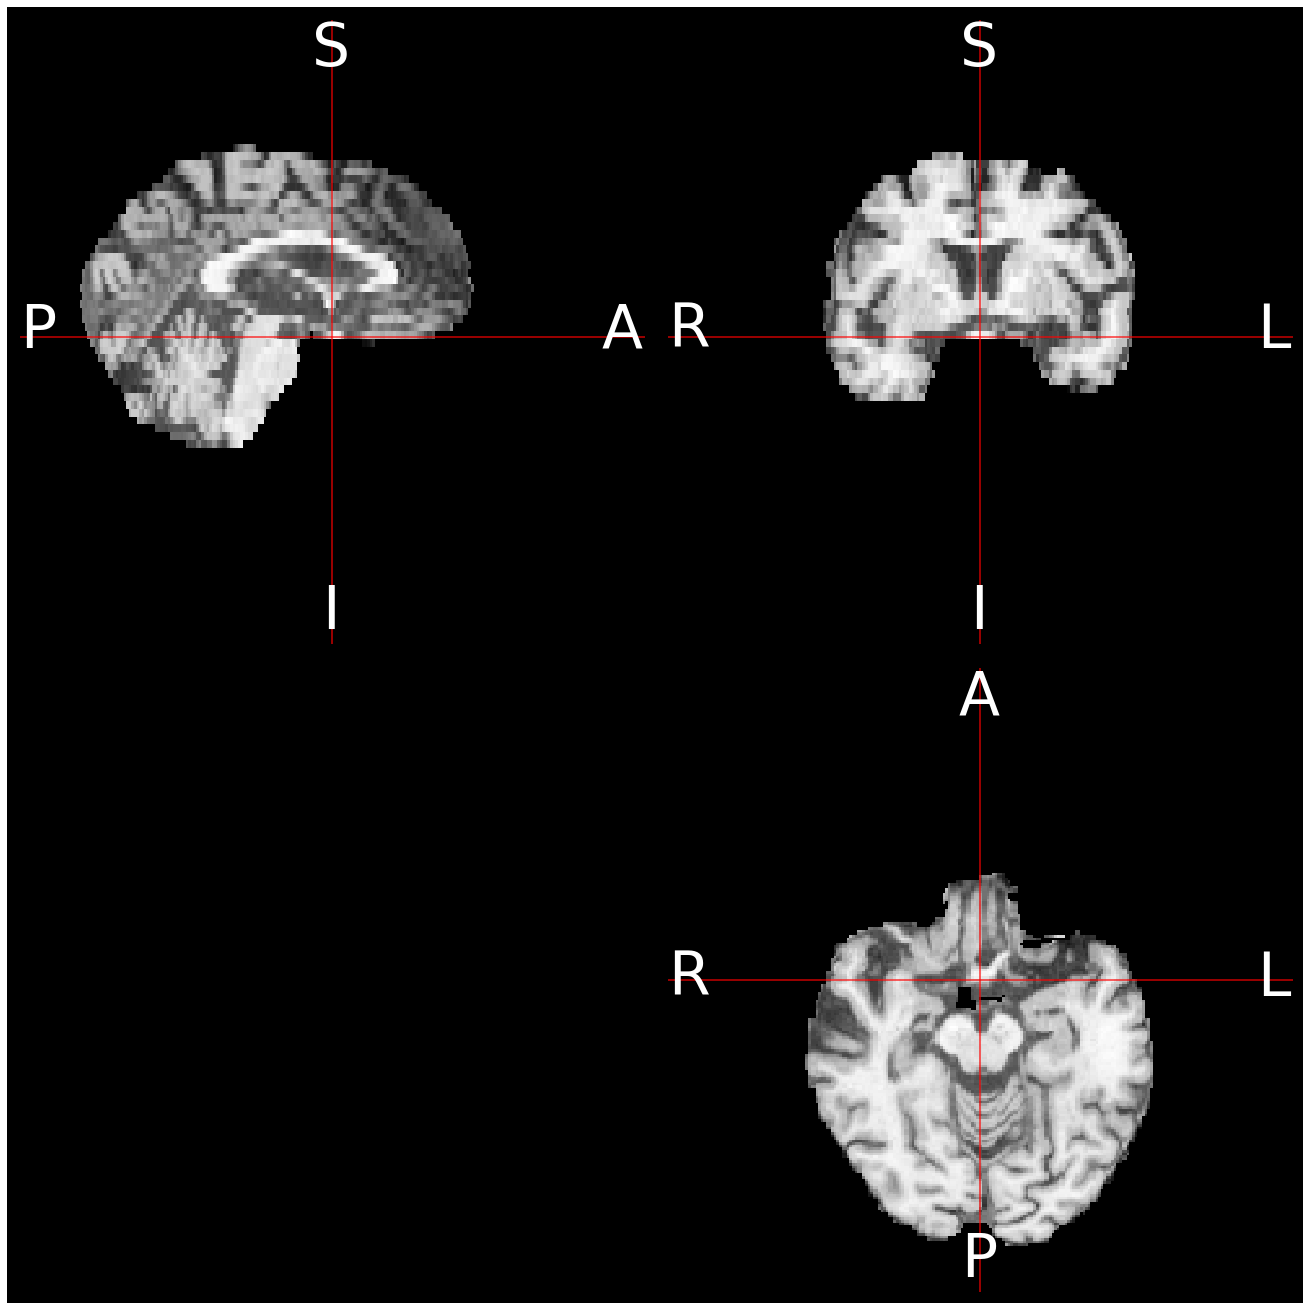

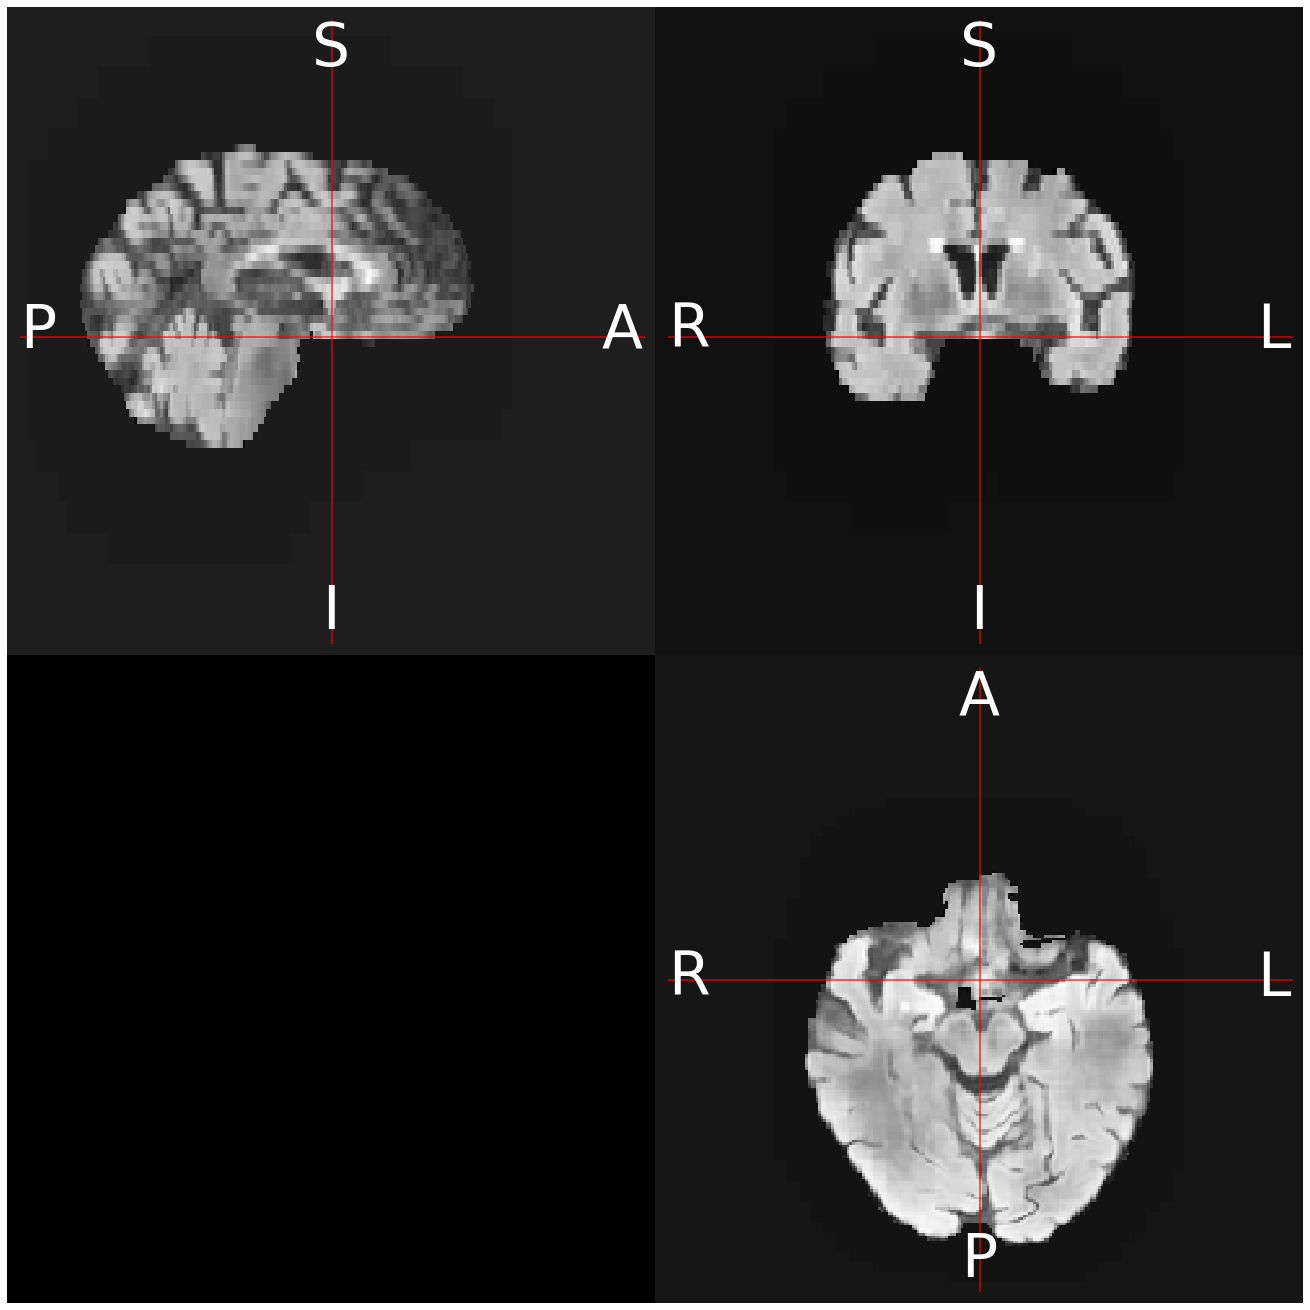

In [58]:
# reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
flair_image = reconstruct_image(flair_out.squeeze(), 
                                coordenates, 
                                scan.shape)

# save as nifti image is necessary
flair_scan = ants.from_numpy(flair_image)
flair_scan = ants.copy_image_info(scan, flair_scan)
flair_scan.to_filename(os.path.join(options['test_path'], '107', 'FLAIR_syn.nii.gz'))

scan.plot_ortho(figsize=3)
flair_scan.plot_ortho(figsize=3)